In [0]:
from fastai import *
from fastai.vision import *
from fastai.vision.models import *
import matplotlib.pyplot as plt
from fastai.metrics import psnr
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import random
from skimage import io
from PIL import Image

## 0. Downloading the data and taking a look at it

In [2]:
path = untar_data(URLs.IMAGENETTE_160)

In [0]:
img = plt.imread(path/'train/n01440764/n01440764_13464.JPEG')

In [4]:
img.shape

(160, 178, 3)

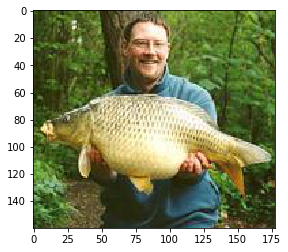

In [5]:
plt.imshow(img)

## 1. Creating the Datasets and Dataloaders

In [0]:
files = os.listdir(path/'train/n01440764')

In [0]:
idx =  random.sample(range(0, len(files)), int(len(files)*0.2))

files_series = pd.Series(files)

files_val = list(files_series.loc[idx])
files_train = list(files_series.drop(idx))

In [0]:
class CustomDataset(Dataset):
    def __init__(self,root, files, window_size=30, tfms=None):
        self.root = root
        self.files = files
        self.window_size=window_size
        self.tfms = tfms
        
    def __len__(self): return len(self.files)
        
    def show(self,idx):
        sample = self.__getitem__(idx)
        #fig=plt.figure(figsize=(5, 5))
        f, ax = plt.subplots(1,2)
        #import pdb;pdb.set_trace()
        stds = np.array([0.229, 0.224, 0.225])
        means = np.array([0.485, 0.456, 0.406])
        x = (sample[0].numpy().transpose((1,2,0))*stds + means)*255
        y = (sample[1].numpy().transpose((1,2,0))*stds + means)*255
        ax[0].imshow(x.astype(np.uint8))
        ax[1].imshow(y.astype(np.uint8))    
        
            
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #import pdb;pdb.set_trace()
        img = io.imread(self.root + '/' + self.files[idx])
        #import pdb;pdb.set_trace()
        #img = img.transpose((2,0,1))
        #img = torch.from_numpy(img)
        
        if self.tfms: 
            #import pdb;pdb.set_trace()
            img = self.tfms(Image.fromarray(img))
            #import pdb;pdb.set_trace()

        
        row_init = np.random.randint(0,img.shape[1]-self.window_size)
        col_init = np.random.randint(0,img.shape[2]-self.window_size)
        #import pdb;pdb.set_trace()
        target = img[:,row_init:row_init+self.window_size,col_init:col_init+self.window_size]
        img_window = img.clone()
        img_window[0,row_init:row_init+self.window_size,col_init:col_init+self.window_size] = (0-0.485)/0.229
        img_window[1,row_init:row_init+self.window_size,col_init:col_init+self.window_size] = (0-0.456)/0.224
        img_window[2,row_init:row_init+self.window_size,col_init:col_init+self.window_size] = (0-0.406)/0.225


        sample = (img_window,img)
        
        return sample

In [0]:
tfms = transforms.Compose([
        transforms.RandomResizedCrop(160,scale=(0.8,1)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [0]:
train_ds = CustomDataset(str(path)+'/train/n01440764',files_train,tfms=tfms,window_size=32)
valid_ds = CustomDataset(str(path)+'/train/n01440764',files_val,tfms=tfms,window_size=32)

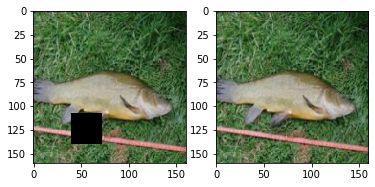

In [83]:
train_ds.show(0)

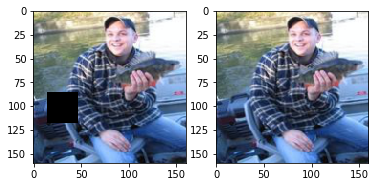

In [84]:
valid_ds.show(0)

In [0]:
train_dl = DataLoader(train_ds, batch_size=16,shuffle=True,num_workers=2)
valid_dl = DataLoader(train_ds, batch_size=16,shuffle=True,num_workers=2)

In [0]:
inputs, classes = next(iter(train_dl))

In [92]:
inputs.shape, classes.shape

(torch.Size([16, 3, 160, 160]), torch.Size([16, 3, 160, 160]))

## 2. Creating the model

In [139]:
mdl = models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
encoder = nn.Sequential(*list(mdl.children())[:-2])

In [141]:
c = encoder(inputs)
c.shape

torch.Size([16, 512, 5, 5])

In [0]:
#Putting a decoder on top of my encoder
fillNet = DynamicUnet(encoder, 3, img_size=(160,160),self_attention=True)

In [0]:
#making shure my outputs match de window size
class LastLayer(nn.Module):
    def __init__(self):
        super(LastLayer,self).__init__()
        self.conv = nn.Conv2d(3,3,(3,3),(5,5),(1,1), bias=False)
        self.bn = nn.BatchNorm2d(3)
    def forward(self,x):
        x = F.relu(self.conv(x))
        return self.bn(x)

In [0]:
#fillNet = nn.Sequential(fillNet,LastLayer())

In [90]:
bla = fillNet(inputs)
bla.shape

torch.Size([16, 3, 160, 160])

## 3. Creating the Databunch and Learner

In [0]:
data = DataBunch(train_dl,valid_dl)

In [0]:
learn = Learner(data, fillNet, loss_func=nn.MSELoss(), metrics = [psnr], callback_fns=ShowGraph)

In [0]:
#creating the layer groups so that I can use discriminative learning rates
learn.split([learn.model.layers[:4], learn.model.layers[4:8], learn.model.layers[8:]])

In [0]:
#for i,param in enumerate(learn.model.parameters()):
#    param.requires_grad = True

In [146]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.90E-04
Min loss divided by 10: 2.40E-01


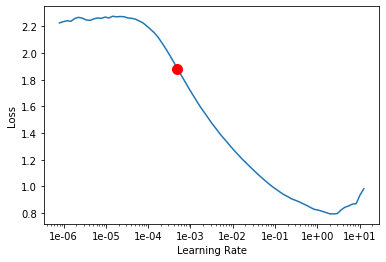

In [147]:
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,psnr,time
0,1.423504,0.913043,0.403196,00:19
1,0.660199,0.364012,4.399305,00:20
2,0.345083,0.132010,8.800348,00:20
3,0.204616,0.080847,10.937408,00:20
4,0.145183,0.073586,11.344831,00:20
5,0.106377,0.055497,12.568472,00:20
6,0.093049,0.076514,11.174137,00:20
7,0.083888,0.050102,13.018246,00:20
8,0.070263,0.040839,13.901291,00:20
9,0.063686,0.034143,14.695939,00:20


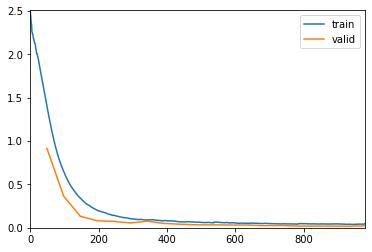

Better model found at epoch 0 with valid_loss value: 0.913043200969696.
Better model found at epoch 1 with valid_loss value: 0.3640119731426239.
Better model found at epoch 2 with valid_loss value: 0.13200968503952026.
Better model found at epoch 3 with valid_loss value: 0.0808473750948906.
Better model found at epoch 4 with valid_loss value: 0.07358638942241669.
Better model found at epoch 5 with valid_loss value: 0.05549687519669533.
Better model found at epoch 7 with valid_loss value: 0.05010195076465607.
Better model found at epoch 8 with valid_loss value: 0.04083868861198425.
Better model found at epoch 9 with valid_loss value: 0.03414275869727135.
Better model found at epoch 10 with valid_loss value: 0.03389989584684372.
Better model found at epoch 11 with valid_loss value: 0.031713299453258514.
Better model found at epoch 12 with valid_loss value: 0.03162110596895218.
Better model found at epoch 13 with valid_loss value: 0.024319853633642197.
Better model found at epoch 15 with 

In [148]:
learn.fit_one_cycle(20, max_lr=4.9e-4,
                    callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='stage-1.1')],)

In [0]:
def show_results(learn,figsize=(5,5)):
    inputs,classes = next(iter(learn.data.valid_dl))
    preds = learn.model(inputs)
    stds = np.array([0.229, 0.224, 0.225])
    means = np.array([0.485, 0.456, 0.406])
    inp = (inputs[0].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255
    target = (classes[0].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255
    pred = (preds[0].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255

    mse = np.sum(((pred - target)**2))/(pred.shape[0]*pred.shape[1]*pred.shape[2])
    psnr = 10*np.log10(255/mse)

    print('MSE:',mse)
    print('PSNR:', psnr)

    #import pdb;pdb.set_trace()

    fig = plt.figure(figsize=figsize)
    ax0 = fig.add_subplot(131)
    ax0.imshow(inp.astype(np.uint8))
    ax0.title.set_text('Input')
    ax1 = fig.add_subplot(132)
    ax1.imshow(target.astype(np.uint8))
    ax1.title.set_text('Target')
    ax2 = fig.add_subplot(133)
    ax2.imshow(pred.astype(np.uint8))
    ax2.title.set_text('Prediction')

In [0]:
learn.load('stage-1.1')

MSE: 20.22805309593607
PSNR: 11.005860955069771


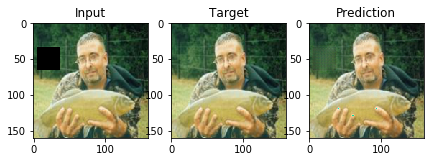

In [157]:
show_results(learn,figsize=(7,7))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


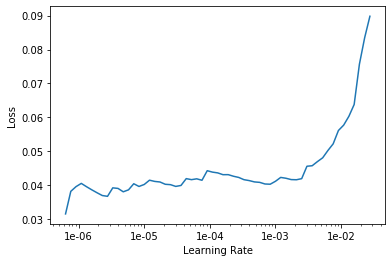

In [158]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,psnr,time
0,0.038514,0.022881,16.440672,00:20
1,0.043295,0.030576,15.162951,00:20
2,0.044938,0.021368,16.748697,00:20
3,0.040329,0.025471,15.974122,00:20
4,0.045899,0.025865,15.898199,00:20
5,0.043694,0.021624,16.701147,00:20
6,0.046655,0.020764,16.901930,00:20
7,0.038306,0.020915,16.842127,00:20
8,0.043587,0.018143,17.457243,00:20
9,0.041401,0.022433,16.521454,00:20


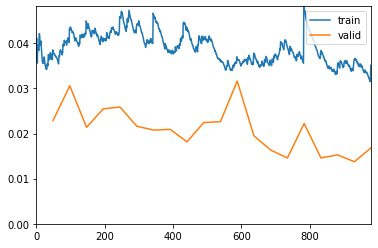

Better model found at epoch 0 with valid_loss value: 0.022881167009472847.
Better model found at epoch 2 with valid_loss value: 0.021368449553847313.
Better model found at epoch 6 with valid_loss value: 0.020764023065567017.
Better model found at epoch 8 with valid_loss value: 0.01814260147511959.
Better model found at epoch 13 with valid_loss value: 0.016339728608727455.
Better model found at epoch 14 with valid_loss value: 0.014575622044503689.
Better model found at epoch 18 with valid_loss value: 0.01375418622046709.


In [159]:
learn.fit_one_cycle(20, slice(1e-6,1e-3),
                    callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='stage-2')])

MSE: 25.24085509769726
PSNR: 10.04436116790508


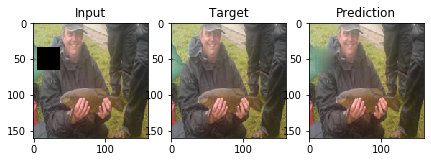

In [172]:
show_results(learn,figsize=(7,7))